In [1]:
import pandas as pd 
import numpy as np
from scipy.stats import pearsonr
import networkx as nx
import matplotlib.pyplot as plt
import pickle
import os
from multiprocessing import Pool
#import deepgraph as dg

In [2]:
LGG = pd.read_csv("unc.edu_LGG_IlluminaHiSeq_RNASeqV2.geneExp.tsv", sep='\t')
LUCS = pd.read_csv("unc.edu_LUSC_IlluminaHiSeq_RNASeqV2.geneExp.tsv", sep='\t')
PRAD = pd.read_csv("unc.edu_PRAD_IlluminaHiSeq_RNASeqV2.geneExp.tsv", sep = '\t')

In [3]:
def get_drivers(filename):
    drivers = pd.read_csv(filename, sep = '\t')
    return  drivers['SYMBOL']

In [4]:
LUCS_drivers =set(get_drivers("intogen-LUSC-LUSC_TCGA-drivers-data.tsv"))
LGG_drivers = set(get_drivers("intogen-LGG-LGG_TCGA-drivers-data.tsv"))
PRAD_drivers = set(get_drivers("intogen-PRAD-drivers-data.tsv"))

In [5]:
def locate_drivers(gene_ids, drivers):
    locs = []
    for i, gene_id in gene_ids.iteritems():
        gene_name = gene_id[:gene_id.index('|')]
        if gene_name in drivers:
            locs.append(i)
    return locs

In [6]:
lgg_driver_locs = locate_drivers(LGG["gene_id"], LGG_drivers)
lucs_driver_locs = locate_drivers(LUCS["gene_id"], LUCS_drivers)
prad_driver_locs = locate_drivers(PRAD["gene_id"], PRAD_drivers)

In [7]:
def write_to_file(filename, data):
    outfile = open(filename, 'wb')
    pickle.dump(data, outfile)
    outfile.close()


def load_pkl(filename):
    file = open(filename, 'rb')
    object_file = pickle.load(file)
    file.close()
    return object_file

In [8]:
lgg_driver_pmatrix = load_pkl("lgg_driver_pearson_matrix.p")

991025 1006019


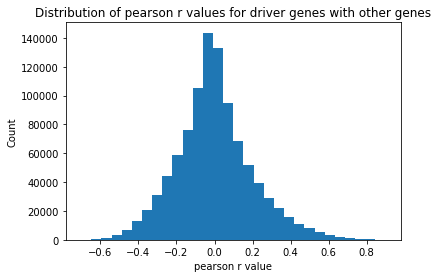

In [9]:
# distribution of correlation values
p_value_drivers = []
for driver in lgg_driver_locs:
    ps = lgg_driver_pmatrix[driver][:]
    for i in range(len(ps)):
        if i != driver and not np.isnan(ps[i]):
            p_value_drivers.append(ps[i])
    #p_value_drivers.extend(lgg_driver_pmatrix[driver][:])
print (len(p_value_drivers), LGG.shape[0]*len(lgg_driver_locs))
plt.hist(p_value_drivers, bins=30)
plt.ylabel("Count")
plt.xlabel("pearson r value")
plt.title("Distribution of pearson r values for driver genes with other genes")
plt.savefig("dist.png")
plt.show()

In [11]:
# Build a graph with driver genes with rest of genes, edges are created when p values are above threshold
# actual name=True then node name will be actual gene id
# actual name=False, node name is row index
def build_graph_drivers_threshold(data, adj_matrix, drivers, threshold, actual_name):
    # undirected, weighted graph
    G = nx.Graph()
    for i in range(len(adj_matrix)):
        if actual_name:
            G.add_node(data["gene_id"].iloc[i])
        else:
            G.add_node(i)
        
    for i in drivers:
        for j in range(len(adj_matrix)):
            if i != j:
                if not np.isnan(adj_matrix[i][j]) and abs(adj_matrix[i][j]) > threshold: 
                    if actual_name:
                        G.add_edge(data["gene_id"].iloc[i], data["gene_id"].iloc[j], weight=adj_matrix[i][j])
                    else:
                        G.add_edge(i, j, weigt=adj_matrix[i][j])
    return G

In [12]:
G_driver_threshold = build_graph_drivers_threshold(LGG, lgg_driver_pmatrix, lgg_driver_locs, 0.7, False)

In [13]:
print ("Number of nodes: ", nx.number_of_nodes(G_driver_threshold) == len(lgg_driver_pmatrix))
print ("Number of selfloop: ", nx.number_of_selfloops(G_driver_threshold))
print ("nodes number: {}, edges number: {}".format(nx.number_of_nodes(G_driver_threshold), nx.number_of_edges(G_driver_threshold)))
print ("Number of connected components: ", nx.number_connected_components(G_driver_threshold))

Number of nodes:  True
Number of selfloop:  0
nodes number: 20531, edges number: 1910
Number of connected components:  19207


In [14]:
# remove isolated nodes that are not connected to driver gene
required_genes = []
for g in nx.connected_component_subgraphs(G_driver_threshold):
    if len(g.nodes) >= 1:
        genes = list(g.nodes)
        for gene in genes:
            if gene in lgg_driver_locs:
                required_genes.extend(genes)
                #print ("Yes", len(g.nodes))
                #print (genes)
                break
print (len(required_genes))

1357


In [15]:
# recompute pearson matrix disregarding isolated nodes
# calculate pearson for driver gene with other genes
# Pearson Correlation
def calculate_pearson_required(required, data):
    '''
    Input: driver gene location in data and data
    Output: Person matrix
    '''
    n = len(required)
    pmatrix = np.empty((n, n))
    mappings = {}
    print (pmatrix.shape)
    
    for i in range(len(required)):
        data_i = required[i]
        mappings[i] = data_i
        gene1 = np.array(data.iloc[data_i, :].values)[1:]
        for j in range(len(required)):
            data_j = required[j]
            gene2 = np.array(data.iloc[data_j, :].values)[1:]
            # note: if either one of gene is all zeros, r and p are nan
            r, p= pearsonr(gene1, gene2)
            pmatrix[i][j] = r
        if i % 100 == 0:
            print (i)
    return pmatrix, mappings

In [16]:
# pmatrix_required, mappings = calculate_pearson_required(required_genes, LGG)

(1357, 1357)
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300


In [26]:
# write_to_file("pmatrix_required.p", pmatrix_required)
# write_to_file("mappings.p", mappings)

In [27]:
pmatrix_required = load_pkl("pmatrix_required.p")
mappings = load_pkl("mappings.p")

In [28]:
pmatrix_require.shape

(1357, 1357)

In [29]:
# rebuild the graph with genes from mappings
# the graph is now fully connected
def build_graph_required(data, adj_matrix, mappings, actual_name):
    # undirected, weighted graph
    G = nx.Graph()
    for i in range(len(adj_matrix)):
        if actual_name:
            G.add_node(data["gene_id"].iloc[mappings[i]])
        else:
            G.add_node(mappings[i])
        for j in range(i+1, len(adj_matrix)):
            if not np.isnan(adj_matrix[i][j]) and adj_matrix[i][j] != 0: 
                if actual_name:
                    G.add_edge(data["gene_id"].iloc[mappings[i]], data["gene_id"].iloc[mappings[j]], weight=adj_matrix[i][j])
                else:
                    G.add_edge(mappings[i], mappings[j], weigt=adj_matrix[i][j])
    return G

In [30]:
graph_required = build_graph_required(LGG, pmatrix_required, mappings, False)

In [22]:
print ("Number of selfloop: ", nx.number_of_selfloops(graph_required))
print ("nodes number: {}, edges number: {}".format(nx.number_of_nodes(graph_required), nx.number_of_edges(graph_required)))
print ("Number of connected components: ", nx.number_connected_components(graph_required))

Number of selfloop:  0
nodes number: 1357, edges number: 920046
Number of connected components:  1


In [23]:
# centrality
def centrality(G):
    betweenness = nx.betweenness_centrality(G, normalized=True, weight="weight")
    eigenvec = nx.eigenvector_centrality_numpy(G, weight="weight")
    degree = nx.degree_centrality(G)
    closeness = nx.closeness_centrality(G)
    return degree, betweenness, closeness, eigenvec

In [24]:
# Other centralities don't not work since edge weight is negative, and there is cycle in graph
# degree centrality is all 1s cuz fully connected
# degree, betweenness, closeness, eigenvec = centrality(graph_required)

In [25]:
# build a dataframe for genes and their centrality values
def build_dataframe_required(data, inputs, mappings, actual_name):
    #inputs is dictionaries within dictionaries
    # outer dict: key= centrality type, value: dictionary of computed values for all genes
    # inner dict: key= gene id (index or actual name), value: centrality value for the gene id
    gene_ids = []
    for key in mappings.keys():
        data_index = mappings[key]
        gene_id = data["gene_id"].iloc[data_index]
        gene_ids.append(gene_id)
    centrality_df = pd.DataFrame({"gene id": gene_ids})
        
    for centrality in inputs.keys():
        values = []
        for i in mappings.keys():
            data_index = mappings[i]
            if actual_name:
                values.append(inputs[centrality][data["gene_id"].iloc[data_index]])
            else:
                values.append(inputs[centrality][data_index])
        centrality_df[centrality] = pd.DataFrame(values)
    return centrality_df

In [ ]:
# inputs = {"degree": degree, "betweenness": betweenness, "closeness": closeness, "eigenvector": eigenvec}
# centrality_df = build_dataframe_required(LGG, inputs, mappings, False)
# centrality_df.shape